<a href="https://colab.research.google.com/github/nascimento-luciano/Artificial-Intelligence/blob/master/Analise_COVID_19_Brasil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1ª Etapa - Plotagem do Casos Confirmados de COVID-19 no Brasil

In [111]:
#---------------------------------Parte 1---------------------------------------
#Importanto bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import geopandas as gpd -----> Verificar porque não carrega a biblioteca
import plotly.express as px
import plotly.graph_objects as go

In [112]:
#Importação da biblioteca geopandas via instalação no Colab
!pip install geopandas

In [113]:
#---------------------------------Parte 2---------------------------------------
#Importando Arquivo CSV
#Dados não "Oficiais de 2020"
covid_cases = pd.read_csv('worldometer_coronavirus_daily_data.csv')
covid_vaxxs = pd.read_csv('country_vaccinations.csv')
df = pd.read_csv('covid_19_data.csv')
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
sub=pd.read_csv('submission.csv')
submission=pd.read_csv('submission.csv')
confirmed_df = pd.read_csv('time_series_covid_19_confirmed.csv')

In [114]:
#---------------------------------Parte 3---------------------------------------
#Vamos marcar o datase e usar como amostra o Brazil

def fix_country_name(country):
    name_dict = {
        'BRA': 'Brazil'
     }
    try:
      return name_dict[country]
    except KeyError:
      return country

covid_cases.country = covid_cases.country.apply(fix_country_name)

In [115]:
#---------------------------------Parte 4---------------------------------------
#Vamos observar o caso do Brasil
countries_of_interest = ["Brazil"]

#Vamos começar a limpar os dados filtrando-o para o subconjunto de países que desejamos.
covid_cases_subset = covid_cases[covid_cases.country.isin (countries_of_interest)]
covid_vaxxs_subset = covid_vaxxs[covid_vaxxs.country.isin (countries_of_interest)]

In [116]:
#---------------------------------Parte 5---------------------------------------
#Unindo os databases usando as datas e países
merged_data = pd.merge_ordered(covid_cases_subset, covid_vaxxs_subset, \
                               left_on=['date', 'country'], \
                               right_on=['date', 'country'])

#Remove as colunas desnecessárias
merged_data.drop(columns=['iso_code', 'source_name', 'source_website', 'vaccines',\
                           'daily_vaccinations_per_million', 'daily_vaccinations_raw'], inplace=True)

In [117]:
#---------------------------------Parte 6---------------------------------------
#Vamos lidar com os NaNs
merged_data.fillna({'total_vaccinations':0, 'people_vaccinated':0, 'people_fully_vaccinated':0,\
                 'daily_vaccinations':0,'total_vaccinations_per_hundred':0,\
                 'people_vaccinated_per_hundred':0 ,'people_fully_vaccinated_per_hundred':0}\
                 ,inplace=True)

covid_data = merged_data.dropna(how='any', subset=['cumulative_total_cases'])

In [118]:
#---------------------------------Parte 7---------------------------------------
#Vamos também definir o índice para a data
covid_data.set_index('date', inplace=True)

In [119]:
#Vamos mudar o índice para um objeto datetime agora
covid_data.index = pd.to_datetime(covid_data.index, errors='coerce', infer_datetime_format=True)

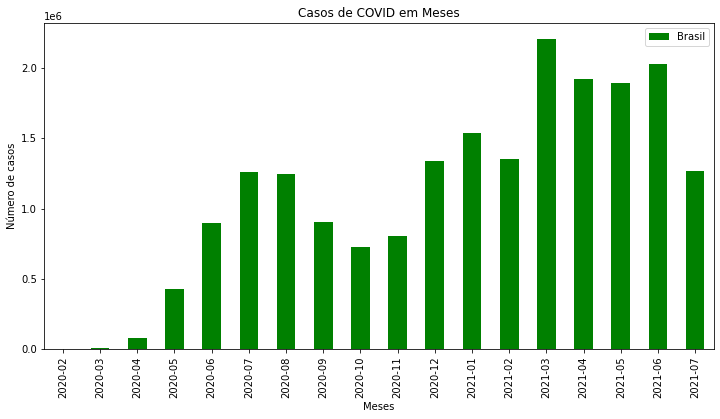

In [120]:
#---------------------------------Parte 8---------------------------------------
#Plotagem do casos de COVID-19 no Brasil em forma de barras
BRA_infections = covid_data[covid_data.country == 'Brazil']

plt.figure(figsize=(12, 6))
BRA_infections['daily_new_cases']\
  .groupby(BRA_infections.index.to_period('M'))\
  .sum().plot(kind='bar', legend=False, color='g')

plt.legend(['Brasil'])
plt.ylabel('Número de casos')
plt.xlabel('Meses')
plt.title('Casos de COVID em Meses');

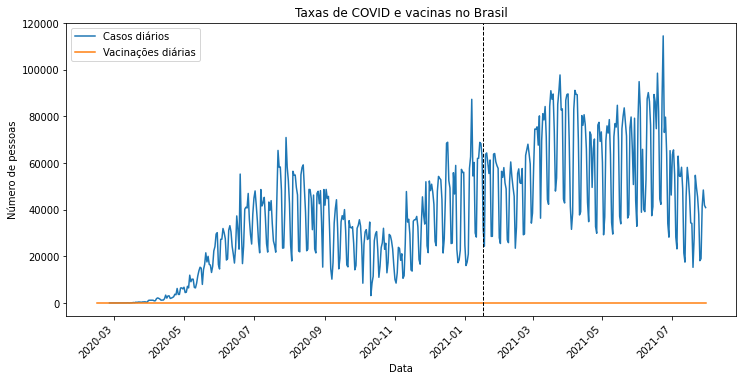

In [121]:
#---------------------------------Parte 9---------------------------------------
#Vemos que o padrão muda de país para país
plt.figure(figsize=(12, 6))
covid_data[covid_data.country == 'Brazil'].daily_new_cases.plot(legend=False,rot=45)
covid_data[covid_data.country == 'Brazil'].daily_vaccinations.plot(legend=False,rot=45)

#Marca o início do lançamento da vacina  no Brazil -----> Mônica Calazans (Primeiro Vacinado)
plt.axvline('17/01/2021', color='k', linestyle='dashed', linewidth=1)

plt.legend(['Casos diários', 'Vacinações diárias'])
plt.ylabel('Número de pessoas')
plt.xlabel('Data')
plt.title('Taxas de COVID e vacinas no Brasil');

#É possível conferir se os gráficos abaixo estão certo,
#checando nos sites da Wikipedia e Our World Data
#https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Brazil
#https://ourworldindata.org/coronavirus/country/brazil

--------------------------Fim do Código---------------------------------------

2ª Etapa - Plotagem do Modelo de Predição de Casos de Confirmados no Brasil

In [122]:
#---------------------------------Parte 1---------------------------------------
#Importanto bibliotecas
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
import bokeh 
from bokeh.io import output_notebook
from bokeh.resources import INLINE
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
output_notebook(resources=INLINE)
%matplotlib inline

In [123]:
#---------------------------------Parte 2---------------------------------------
#Construindo o DataFrame a partir de um arquivo CSV.
train = pd.DataFrame(pd.read_csv('train.csv'))

In [124]:
#Platagem da forma de treinamento
print("A forma dos dados de treinamento é = {}".format(train.shape))

A forma dos dados de treinamento é = (35995, 6)


In [125]:
#---------------------------------Parte 3---------------------------------------
#Considerando para o treinamento os dados das Provincias, Casos Confirmados e Fatalidades
train.Province_State.fillna("", inplace = True)
train.ConfirmedCases.fillna("", inplace = True)
train.Fatalities.fillna("", inplace = True)

In [126]:
#---------------------------------Parte 4---------------------------------------
#Treinamento exibe a forma matricial dos países com casos confirmados de COVID-19
train["Country_Region"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guinea', 'Guine

In [127]:
#---------------------------------Parte 5---------------------------------------
#Aqui separamos os casos confimados e os casos fatais de COVID-19 no Brazil
confirmed_cases_brazil = train[train["Country_Region"] == "Brazil"].groupby(["Date"]).ConfirmedCases.sum()
fatal_cases_brazil = train[train["Country_Region"] == "Brazil"].groupby(["Date"]).Fatalities.sum()

In [128]:
#---------------------------------Parte 6---------------------------------------
#Fazendo o treinamento para Paíse/Região
train_brazil = train[train["Country_Region"] == "Brazil"]
train_brazil

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
3450,3451,,Brazil,2020-01-22,0.0,0.0
3451,3452,,Brazil,2020-01-23,0.0,0.0
3452,3453,,Brazil,2020-01-24,0.0,0.0
3453,3454,,Brazil,2020-01-25,0.0,0.0
3454,3455,,Brazil,2020-01-26,0.0,0.0
...,...,...,...,...,...,...
3560,3561,,Brazil,2020-05-11,169594.0,11653.0
3561,3562,,Brazil,2020-05-12,178214.0,12461.0
3562,3563,,Brazil,2020-05-13,190137.0,13240.0
3563,3564,,Brazil,2020-05-14,203165.0,13999.0


In [129]:
#---------------------------------Parte 7--------------------------------------
#Analisando os casos confimados e casos fatais
train_brazil["ConfirmedCases"] = train_brazil["ConfirmedCases"].astype(int)
train_brazil["Fatalities"] = train_brazil["Fatalities"].astype(int)

In [130]:
#---------------------------------Parte 8---------------------------------------
#Aqui vemos o tamanho do treinamento e da validação 
train_brazil_size = int(len(train_brazil) * 0.75)
val_brazil_size = len(train_brazil) - train_brazil_size
print("Training size = {}".format(train_brazil_size))
print("Validation size = {}".format(val_brazil_size))

Training size = 86
Validation size = 29


In [131]:
#---------------------------------Parte 9---------------------------------------
#Treinamento os casos confimados e casos fatais
train_brazil_confirmed_cases = train_brazil[["ConfirmedCases"]]
train_brazil_fatal_cases = train_brazil[["Fatalities"]]

In [132]:
#PLotagem do casos confirmados e fatais em forma de matriz
print(train_brazil_confirmed_cases, train_brazil_fatal_cases)

      ConfirmedCases
3450               0
3451               0
3452               0
3453               0
3454               0
...              ...
3560          169594
3561          178214
3562          190137
3563          203165
3564          220291

[115 rows x 1 columns]       Fatalities
3450           0
3451           0
3452           0
3453           0
3454           0
...          ...
3560       11653
3561       12461
3562       13240
3563       13999
3564       14962

[115 rows x 1 columns]


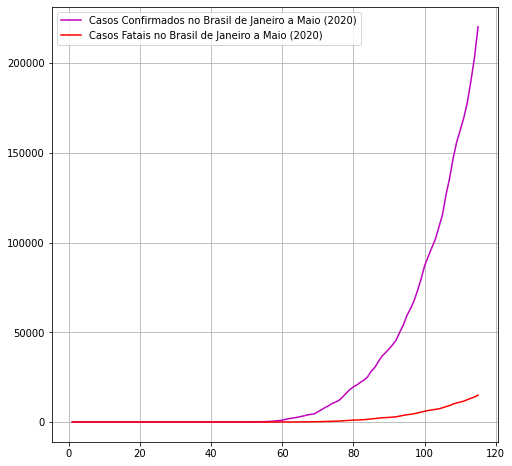

In [133]:
#---------------------------------Parte 11--------------------------------------
#Plotagem dos casos confirmados e casos fatais de Janeiro a Maio (2020)
plt.figure(figsize = (8, 8))
x = np.arange(1, 116, 1)
y1 = train_brazil_confirmed_cases 
y2 = train_brazil_fatal_cases 
plt.plot(x, y1, color = "m", label = "Casos Confirmados no Brasil de Janeiro a Maio (2020)")
plt.plot(x, y2, color = "r", label = "Casos Fatais no Brasil de Janeiro a Maio (2020)")
plt.grid(True)
plt.legend()

In [134]:
#---------------------------------Parte 12--------------------------------------
#O comando len () é uma função embutida que retorna o comprimento (número de itens) de um objeto.
len(train_brazil_confirmed_cases)

115

In [135]:
#---------------------------------Parte 13--------------------------------------
#Treinamento dos casos confirmados de COVID-19 no Brasil
train_brazil_confirmed_cases

,ConfirmedCases
3450,0
3451,0
3452,0
3453,0
3454,0
...,...
3560,169594
3561,178214
3562,190137
3563,203165


In [136]:
#---------------------------------Parte 14--------------------------------------
#Aqui usa-se o iloc para indexação / seleção por posição baseada em localização de inteiros.
train_brazil_confirmed_cases_data = train_brazil_confirmed_cases.iloc[0:train_brazil_size]
val_brazil_confirmed_cases_data = train_brazil_confirmed_cases.iloc[train_brazil_size : len(train_brazil_confirmed_cases)]

In [137]:
#---------------------------------Parte 15--------------------------------------
#Plotagem da fixação de inteiros; treinamento e validação de casos
print(len(train_brazil_confirmed_cases_data))
print(len(val_brazil_confirmed_cases_data))

86
29


In [138]:
#---------------------------------Parte 16--------------------------------------
#O MinMaxScaler faz a estimação de escala e traduz cada recurso individualmente, 
#de modo que esteja no intervalo especificado no conjunto de treinamento, por exemplo. entre zero e um.
scaler = MinMaxScaler(feature_range = (0,1))
def createDataset(train) : 
    train_scaled = scaler.fit_transform(train)
    x_train = [] 
    y_train = []
    time_step = 2
    for i in range(time_step, train_scaled.shape[0]):
        x_train.append(train_scaled[i-time_step : i , 0])
        y_train.append(train_scaled[i, 0])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1 ))
    y_train = np.reshape(y_train, (y_train.shape[0], 1 ))
    return x_train, y_train     

In [139]:
#---------------------------------Parte 17--------------------------------------
#Aqui será definido a criação do dataset (train)
def createDataset(train) : 
    train_scaled = scaler.fit_transform(train)
    x_train = [] 
    y_train = []
    time_step = 2
    for i in range(time_step, train_scaled.shape[0]):
        x_train.append(train_scaled[i-time_step : i , 0])
        y_train.append(train_scaled[i, 0])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1 ))
    y_train = np.reshape(y_train, (y_train.shape[0], 1 ))
    return x_train, y_train   

In [140]:
#---------------------------------Parte 18--------------------------------------
#Conjunto de dados para treinar o respectivo modelo de aprendizado
x_train, y_train = createDataset(train_brazil_confirmed_cases_data)
x_val, y_val = createDataset(val_brazil_confirmed_cases_data)

In [141]:
#---------------------------------Parte 19--------------------------------------
#Plotagem do modelo de aprendizado
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(84, 2, 1) (84, 1)
(27, 2, 1) (27, 1)


In [142]:
#---------------------------------Parte 20--------------------------------------
#Aqui é criado e configurado a rede neural
#LSTM cria camada longa de memória de curto prazo
#A camada Dropout define aleatoriamente as unidades de entrada para 0 
#com uma frequência de taxa em cada etapa durante o tempo de treinamento
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units = 50, return_sequences = True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units = 50, return_sequences = True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units = 50, return_sequences = False))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units = 1))

In [143]:
#Compilação do modelo de treinamento
model.compile(tf.keras.optimizers.Adam(lr = 0.001), loss = "mean_squared_error")

In [144]:
#Sumário com o modelo de treinamento
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 2, 50)             10400     
                                                                 
 dropout_12 (Dropout)        (None, 2, 50)             0         
                                                                 
 lstm_13 (LSTM)              (None, 2, 50)             20200     
                                                                 
 dropout_13 (Dropout)        (None, 2, 50)             0         
                                                                 
 lstm_14 (LSTM)              (None, 2, 50)             20200     
                                                                 
 dropout_14 (Dropout)        (None, 2, 50)             0         
                                                                 
 lstm_15 (LSTM)              (None, 50)               

In [145]:
#---------------------------------Parte 21--------------------------------------
#Um epoch é uma iteração sobre todos os dados x e y fornecidos.
#Um batch_size é o tamanho do lote é um termo usado no aprendizado de máquina, 
#e se refere ao número de exemplos de treinamento utilizados em uma iteração
#sobre todos os dados x e y fornecidos.
EPOCHS = 200
BATCH_SIZE = 1

In [146]:
#---------------------------------Parte 22--------------------------------------
#É possível usar as informações da variável “ history ” para
#verificar a evolução da função de loss e da métrica
with tf.device("/device:GPU:0"):
  history = model.fit(x_train, y_train,epochs = EPOCHS, verbose = 1,
                     batch_size = BATCH_SIZE, validation_data = (x_val, y_val))

Epoch 1/200
84/84 [==============================] - 8s 25ms/step - loss: 0.0626 - val_loss: 0.1661
Epoch 2/200
84/84 [==============================] - 1s 7ms/step - loss: 0.0430 - val_loss: 0.0075
Epoch 3/200
84/84 [==============================] - 1s 7ms/step - loss: 0.0179 - val_loss: 0.0034
Epoch 4/200
84/84 [==============================] - 1s 7ms/step - loss: 0.0063 - val_loss: 0.0090
Epoch 5/200
84/84 [==============================] - 1s 7ms/step - loss: 0.0039 - val_loss: 0.0010
Epoch 6/200
84/84 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 8.7421e-04
Epoch 7/200
84/84 [==============================] - 1s 8ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 8/200
84/84 [==============================] - 1s 7ms/step - loss: 0.0023 - val_loss: 0.0066
Epoch 9/200
84/84 [==============================] - 1s 6ms/step - loss: 0.0064 - val_loss: 0.0078
Epoch 10/200
84/84 [==============================] - 1s 7ms/step - loss: 0.0045 - val_loss: 0.0197
Epoc

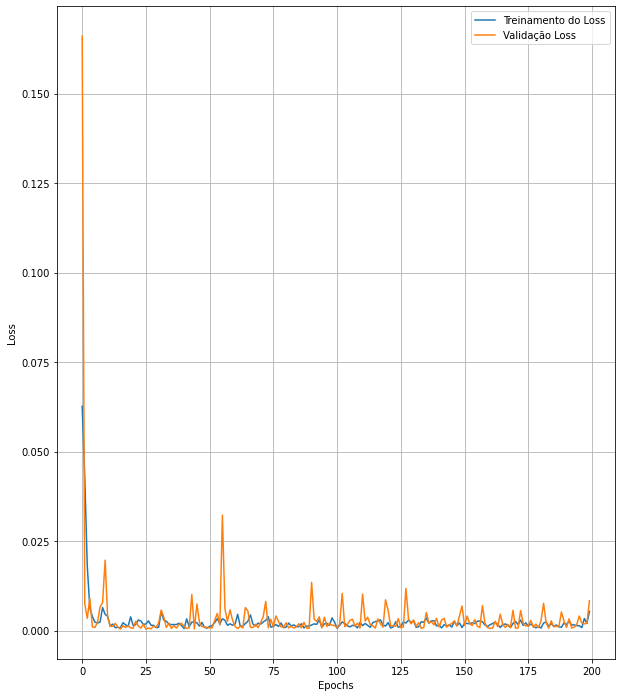

In [147]:
#---------------------------------Parte 23--------------------------------------
#Plotagem do treinamento e validação do Loss
x = np.arange(0, EPOCHS, 1)                                                                  
plt.figure(1, figsize = (22, 12))                                  
plt.subplot(121)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(x, history.history["loss"], label = "Treinamento do Loss")
plt.plot(x, history.history["val_loss"], label = "Validação Loss")
plt.grid(True)
plt.legend()  

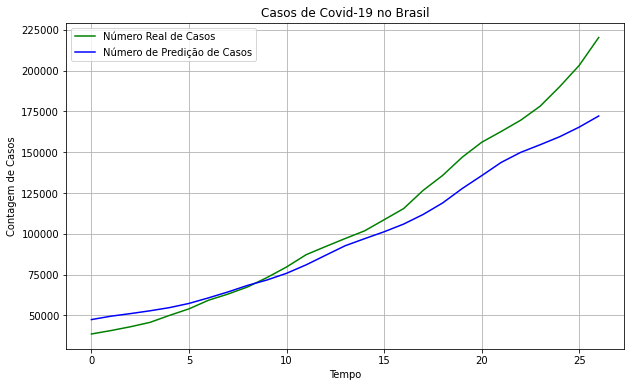

In [148]:
#---------------------------------Parte 24--------------------------------------
#Aqui é possível usar os dados de teste do dataset para,
# essa rede neural treinada, e assim prever as saídas que a rede desconhece
#A seguir são apresentados os casos reais e uma predição rede não conhece;
predicted_cases = model.predict(x_val)
predicted_cases = scaler.inverse_transform(predicted_cases)
real_cases = scaler.inverse_transform(y_val)
plt.figure(figsize= (10, 6))
plt.subplot(1,1,1)
plt.plot(real_cases, color = "green", label = "Número Real de Casos")
plt.plot(predicted_cases, color = "blue", label = "Número de Predição de Casos")
plt.title("Casos de Covid-19 no Brasil")
plt.xlabel("Tempo")
plt.ylabel("Contagem de Casos")
plt.legend()
plt.grid("both")
plt.show()